# Comparison plot - node2vec vs NMF vs prop_model

In [28]:
import pathlib
import numpy as np
import pandas as pd
import networkx as nx
from scipy.spatial import distance
from n2i.__main__ import n2i_main, n2i_nx_graph
from n2i.node2vec import read_graph
from sklearn.decomposition import NMF

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [29]:
# similarity between connected nodes
def sim_in(G):
    sims = []
    for i in G.nodes:
        for j in list(G.neighbors(i)):
            sims.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims)

def select_notedge(G):
    v1 = np.random.choice(G.nodes())
    v2 = np.random.choice(G.nodes())

    while (v1,v2) in G.edges or v1==v2:
        v1 = np.random.choice(G.nodes())
        v2 = np.random.choice(G.nodes())
    return v1, v2
#     n = nx.number_of_nodes(G)
#     while True:
#         a, b = np.random.randint(0, n, size=2)
#         if (a, b) not in G.edges:
#             return a, b

# similarity between disconnected nodes
def sim_out(G, samples):
    sims_out = []
    for c in range(samples):
        i, j = select_notedge(G)
        sims_out.append(1 - distance.cosine(G.nodes[i]['interests'], G.nodes[j]['interests']))
    return np.mean(sims_out)

def homophily(G):
    return sim_in(G) / sim_out(G, 10000)

In [45]:
nr_nodes = 200
G = nx.barabasi_albert_graph(nr_nodes, m=2)
for edge in G.edges():
    G[edge[0]][edge[1]]['weight'] = 1

In [36]:
H_val = [0, 0.5, 1]

dimensions=[10]

## ---------------- node2vec --------------------------

In [38]:
walk_length=[80]
num_walks=[10]
window_size=[10]
iiter=[1]

In [40]:
args_n2v = []

nr_experiments = 10

for d in dimensions:
    for wk in walk_length:
        for n in num_walks:
            for wi in window_size:
                for ii in iiter:
                    for h in H_val:
                        for seed in range(nr_experiments):
                            args = [d, wk, n, wi, ii, h, seed]
                            args_n2v.append(args)

In [6]:
def run_n2v(*args):
    '''
    Returns results list with H instead of p and q of node2vec
    '''
    d, wk, n, wi, ii, h, seed = args
    G_emb = n2i_nx_graph(nx_graph=G, 
             dimensions=d, walk_length=wk,
             num_walks=n, window_size=wi,
             iiter=ii, p=pow(2, -12*h+6), q=pow(2, 12*h-6),
             beta=5,
             alpha_value=0.5,
             beta_value=0.5,
             prior='beta',
             seed=seed+int(1000*(q+p)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 50)
    return args + (si/so,)

In [ ]:
result_n2v = list(map(lambda x: run_n2v(*x), args_n2v))

In [ ]:
df_n2v = pd.DataFrame(result_n2v, columns=['d', 'wk', 'n', 'wi', 'ii', 'h', 'seed', 'hom'])
df_n2v.head()

In [ ]:
df2_n2v = df.groupby(['h'])['hom'].mean()

## --------- propagation model ----------

In [41]:
def propag_emb(G, nr_nodes, nr_topics, steps, perc_influencers, seed=42):
    '''
    generates interests with the propagation method starting from "n" nodes
    '''
    numb_influencers = int(perc_influencers/100 * nr_nodes)
    
    # INITIALIZE
    np.random.seed(seed)
    for i in list(G.nodes):
        interests = np.random.dirichlet(np.ones(nr_topics)*1./nr_topics)
        G.nodes[i]['interests'] = interests
    
    # SELECT INFLUENCERS
    # start with a random node
    influencers = [np.random.choice(G.nodes)]

    for i in range(numb_influencers):
        # calculate distances to current influencers
        sp = {i: nx.shortest_path(G, i) for i in influencers}
        distances = np.array([list(len(sp[j][i]) for j in influencers) for i in G.nodes()])
        # select the node fartest from all influencers
        influencers.append(distances.min(axis=1).argmax()) 
      
    # PROPAGATION STEP
    for c in range(steps):
        i = np.random.choice(nr_nodes)
        interests_i = G.nodes[i]['interests']
        #print(G.nodes[0]['interests'])
        lr = 0.5 if i in influencers else 0.01
        #lr = 0.1
        for j in list(G.neighbors(i)):
            if j in influencers:
                continue
            interests_j = G.nodes[j]['interests']
            interests_j += interests_i * lr
            interests_j /= interests_j.sum()
            G.nodes[j]['interests'] = interests_j
            #print(interests_j)
        

    # preparing matrix
    prop_emb = [G.nodes[_]['interests'] for _ in range(nr_nodes)]
    return np.array(prop_emb)

In [42]:
args_clpa = []

nr_experiments = 10

for d in dimensions:
    for h in H_val:
        for seed in range(nr_experiments):
            args = [d, h, seed]
            args_clpa.append(args)

In [50]:
def run_clpa(*args):
    '''
    Returns list of results with H param instead of steps and percentange of influencers
    '''
    d, h, seed = args
    G_emb =  propag_emb(G, nr_nodes, nr_topics=d, 
                        steps=int(pow(2, 7*h+3)), perc_influencers=pow(2, 7*h-8),
                        seed=seed+int(1000*(h)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    return args + (si/so,)

In [51]:
result_clpa = list(map(lambda x: run_clpa(*x), args_clpa))

In [52]:
df_clpa = pd.DataFrame(result_clpa, columns=['d', 'h', 'seed', 'hom'])
df_clpa.head()

,d,h,seed,hom
0,10,0.0,0,0.876126
1,10,0.0,1,1.148379
2,10,0.0,2,0.985616
3,10,0.0,3,0.970373
4,10,0.0,4,1.067829


In [74]:
df_clpa.groupby(['h'])['hom'].mean()

h
0.0    1.009545
0.5    1.064437
1.0    1.501566
Name: hom, dtype: float64

## ---------------- NMF ----------------

In [63]:
def overlap_generator(G):
    """
    Function to generate a neighbourhood overlap matrix (second-order proximity matrix).
    :param G: Graph object.
    :return laps: Overlap matrix.
    """
    #print("Second order proximity calculation.\n")
    degrees = nx.degree(G)
    sets = {node:set(G.neighbors(node)) for node in nx.nodes(G)}
    laps = np.array([[float(len(sets[node_1].intersection(sets[node_2])))/(float(degrees[node_1]*degrees[node_2])**0.5) if node_1 != node_2 else 0.0 for node_1 in nx.nodes(G)] for node_2 in nx.nodes(G)],dtype = np.float64)
    return laps

In [81]:
def nmf_emb(G, dimensions, seed, eta=0.5, beta=0.):
    A = nx.to_numpy_matrix(G)
    eta = eta
    beta = beta
    S_0 = overlap_generator(G)
    R = np.random.rand(G.number_of_nodes(), G.number_of_nodes())
    
    S = eta*S_0 + A + beta*R
    model = NMF(n_components=dimensions, init='random', random_state=seed)
    W = model.fit_transform(S)
    H = model.components_
    return W

In [82]:
args_nmf = []

nr_experiments = 10

for d in dimensions:
    for h in H_val:
        for seed in range(nr_experiments):
            args = [d, h, seed]
            args_nmf.append(args)

In [83]:
def run_nmf(*args):
    d, h, seed = args
    G_emb =  nmf_emb(G, dimensions=d,  
                        eta=2, beta=16-16*h,
                        seed=seed+int(1000*(e)))
    for i in G.nodes:
        G.node[i]['interests'] = G_emb[i]
    si = sim_in(G)
    so = sim_out(G, 5000)
    return args + (si/so,)

In [84]:
result_nmf = list(map(lambda x: run_nmf(*x), args_nmf))

/Users/Cinus/Library/Python/3.6/lib/python/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [85]:
df_nmf = pd.DataFrame(result_nmf, columns=['d', 'h', 'seed', 'hom'])
df_nmf.head()

,d,h,seed,hom
0,10,0.0,0,1.017046
1,10,0.0,1,0.971415
2,10,0.0,2,0.981429
3,10,0.0,3,0.995139
4,10,0.0,4,0.993739


In [86]:
df2_nmf = df_nmf.groupby(['h'])['hom'].mean()

In [87]:
df2_nmf

h
0.0    0.994753
0.5    1.008106
1.0    3.074720
Name: hom, dtype: float64

## Plot

In [21]:
import seaborn as sns
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [26]:
rand_data = pd.DataFrame([(0) for _ in range(100)])

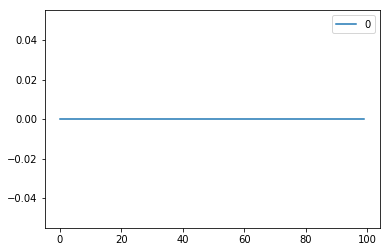

In [27]:
sns.lineplot(data=rand_data, )
plt.show()